In [118]:
from datetime import datetime, timedelta
from sqlmodel import Field, Relationship, SQLModel, Session, create_engine, select, col

CYCLE_TIME = 1      # times in hours
db_name = "beboundless_data.db"
sqlite_url = f"sqlite:///{db_name}"
engine = create_engine(sqlite_url)

In [119]:
from beboundless_data_db import Requestors, Orders

one_hour_ago = int((datetime.now() - timedelta(hours=CYCLE_TIME)).timestamp())
with Session(engine) as session:
    statement = select(Requestors).where(Requestors.last_activity >= one_hour_ago)
    results: list[Requestors] = session.exec(statement).all()

address = [r.address for r in results if r.address]
print(address)

data_dict = {}
with Session(engine) as session:
    for addr in address:
        statement = select(Orders).where(
            Orders.created >= one_hour_ago,
            Orders.requestor_address == addr,
            Orders.lock_gas_price != None
        )
        orders = session.exec(statement).all()
        data_dict[addr] = [(order.order_id, order.created, order.lock_txn, order.lock_gas_price) for order in orders if order.lock_gas_price]
print(data_dict)

['0x2546c553d857d20658ece248f7c7d0861a240681', '0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0', '0x89f12aba0bcda3e708b1129eb2557b96f57b0de6', '0x786deae1d80f8f003320cfc0f6586a7a43acb819']
{'0x2546c553d857d20658ece248f7c7d0861a240681': [('0x2546c553d857d20658ece248f7c7d0861a24068164e631ff', 1757747623, '0xc0dcbd25bd798eb9bf1e6767d693c5d0e3747c50ad2cbb0b9886e9e18d6e539f', 0.421133359), ('0x2546c553d857d20658ece248f7c7d0861a2406814be76b6d', 1757747610, '0x35455447df384717f80133c2b3d15819495856105beb8d112b81f64c66b3d6d0', 0.420677823), ('0x2546c553d857d20658ece248f7c7d0861a240681fcbf8471', 1757747597, '0xfcc3d41585cf3059648769deac458584cdd96d97396eab3ea98c1bb442af7907', 0.343031304), ('0x2546c553d857d20658ece248f7c7d0861a24068166b3430f', 1757747585, '0x9976d74ddc8f4fae7b06ea554a0b2342ca21000366de7214056e05ef7c5e9614', 0.343394449), ('0x2546c553d857d20658ece248f7c7d0861a2406819909b84c', 1757747572, '0x33052c56a9aa3b95f837aff194b6c44a4252390fd35970bfe62f02abe45e4753', 0.309405052), ('0x2546c553

In [120]:
# blacklist = [
#     "0x734df7809c4ef94da037449c287166d114503198",
#     # "0x89f12aba0bcda3e708b1129eb2557b96f57b0de6"
# ]
# data_dict = {addr: orders for addr, orders in data_dict.items() if addr not in blacklist}

whitelist = [
    "0x2546c553d857d20658ece248f7c7d0861a240681",
    "0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0",
]
data_dict = {addr: orders for addr, orders in data_dict.items() if addr in whitelist}

print(data_dict)
if not data_dict:
    raise SystemExit("No data found")

{'0x2546c553d857d20658ece248f7c7d0861a240681': [('0x2546c553d857d20658ece248f7c7d0861a24068164e631ff', 1757747623, '0xc0dcbd25bd798eb9bf1e6767d693c5d0e3747c50ad2cbb0b9886e9e18d6e539f', 0.421133359), ('0x2546c553d857d20658ece248f7c7d0861a2406814be76b6d', 1757747610, '0x35455447df384717f80133c2b3d15819495856105beb8d112b81f64c66b3d6d0', 0.420677823), ('0x2546c553d857d20658ece248f7c7d0861a240681fcbf8471', 1757747597, '0xfcc3d41585cf3059648769deac458584cdd96d97396eab3ea98c1bb442af7907', 0.343031304), ('0x2546c553d857d20658ece248f7c7d0861a24068166b3430f', 1757747585, '0x9976d74ddc8f4fae7b06ea554a0b2342ca21000366de7214056e05ef7c5e9614', 0.343394449), ('0x2546c553d857d20658ece248f7c7d0861a2406819909b84c', 1757747572, '0x33052c56a9aa3b95f837aff194b6c44a4252390fd35970bfe62f02abe45e4753', 0.309405052), ('0x2546c553d857d20658ece248f7c7d0861a24068102edd97e', 1757747560, '0x3c3684cb86836c41b9bfa12471a9d79462ac7f8a3b9c04f3d1e1ff37565052e9', 0.249913908), ('0x2546c553d857d20658ece248f7c7d0861a2406819c

Group stats:
                                      address  count      mean       std  \
0  0x2546c553d857d20658ece248f7c7d0861a240681    191  0.207541  0.137442   
1  0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0    144  0.522390  0.365485   

       min       max    median       q25       q75 best_range  
0  0.01039  0.797756  0.190512  0.102992  0.270545  0.10~0.27  
1  0.00678  1.250723  0.415552  0.223095  0.872443  0.22~0.87  
Good suppliers:
                                      address  count      mean       std  \
0  0x2546c553d857d20658ece248f7c7d0861a240681    191  0.207541  0.137442   
1  0xc2db89b2bd434ceac6c74fbc0b2ad3a280e66db0    144  0.522390  0.365485   

       min       max    median       q25       q75 best_range  
0  0.01039  0.797756  0.190512  0.102992  0.270545  0.10~0.27  
1  0.00678  1.250723  0.415552  0.223095  0.872443  0.22~0.87  
Gas price boxplot:


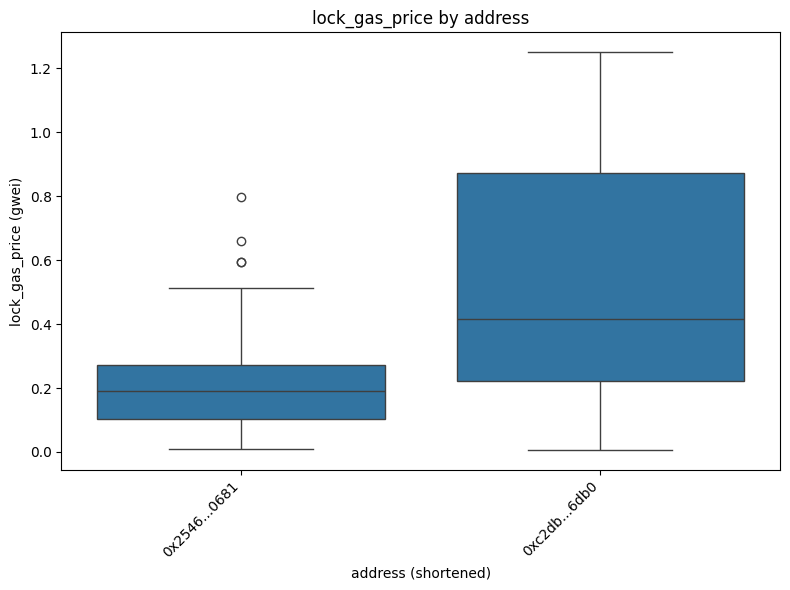

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame([
    {"address": addr, "order_id": oid, "created": created, "lock_txn": txn, "lock_gas_price": float(gas)}
    for addr, lst in data_dict.items()
    for oid, created, txn, gas in lst
])

# set timezone +8
df["created"] = pd.to_datetime(df["created"] + 8 * 3600, unit="s")

from dc_view import plot_gas_price_boxplot, compute_gas_group_stats, filter_good_suppliers

print("Group stats:")
group_stats = compute_gas_group_stats(df)
print(group_stats)

print("Good suppliers:")
good = filter_good_suppliers(group_stats, min_count=10, max_std=5)
print(good)

print("Gas price boxplot:")
plot_gas_price_boxplot(df)

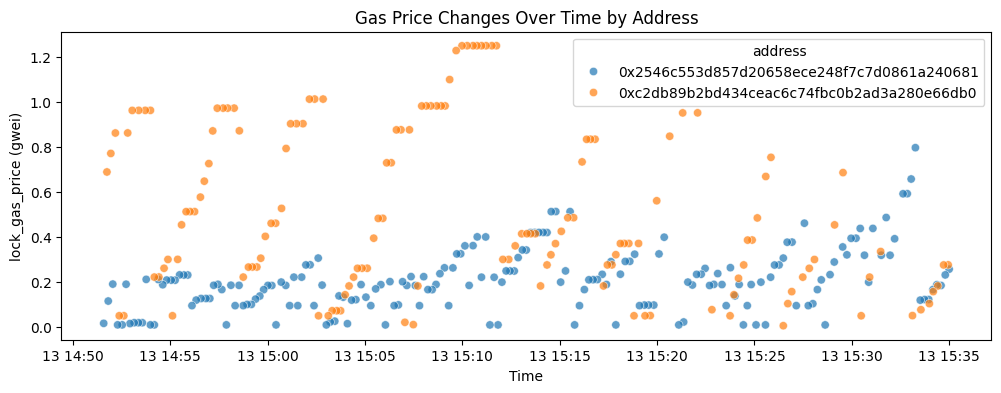

In [122]:
df["created_dt"] = pd.to_datetime(df["created"], unit="s")
plt.figure(figsize=(12, 4))
sns.scatterplot(data=df, x="created_dt", y="lock_gas_price", hue="address", alpha=0.7)
plt.title("Gas Price Changes Over Time by Address")
plt.xlabel("Time")
plt.ylabel("lock_gas_price (gwei)")
plt.show()

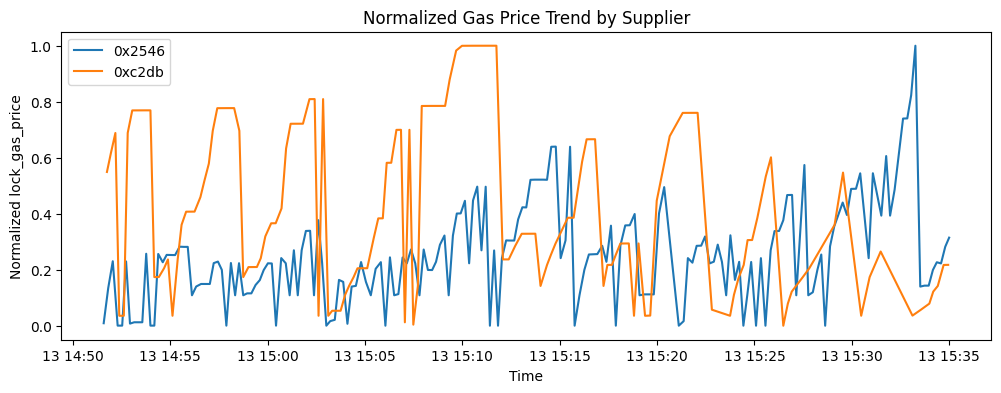

In [123]:
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    norm = (group["lock_gas_price"] - group["lock_gas_price"].min()) / (group["lock_gas_price"].max() - group["lock_gas_price"].min())
    plt.plot(group["created_dt"], norm, label=addr[:6])
plt.legend()
plt.title("Normalized Gas Price Trend by Supplier")
plt.xlabel("Time")
plt.ylabel("Normalized lock_gas_price")
plt.show()

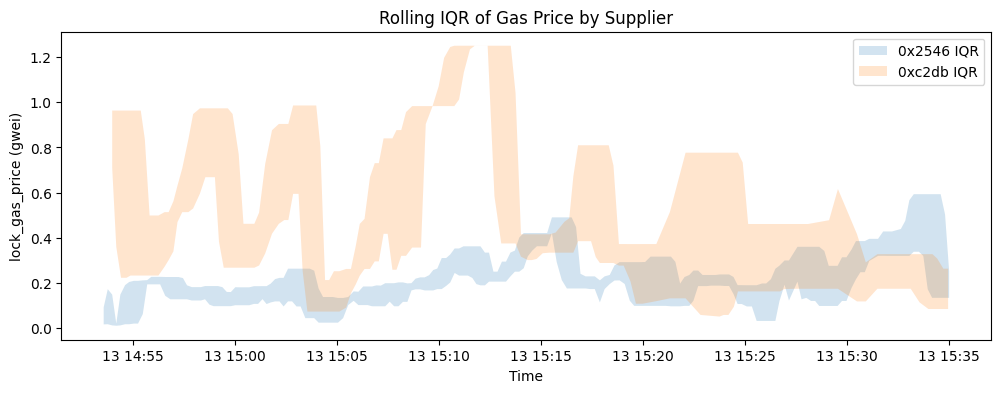

In [124]:
window = 10
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    rolling_q25 = group["lock_gas_price"].rolling(window).quantile(0.25)
    rolling_q75 = group["lock_gas_price"].rolling(window).quantile(0.75)
    plt.fill_between(group["created_dt"], rolling_q25, rolling_q75, alpha=0.2, label=f"{addr[:6]} IQR")
plt.legend()
plt.title("Rolling IQR of Gas Price by Supplier")
plt.xlabel("Time")
plt.ylabel("lock_gas_price (gwei)")
plt.show()


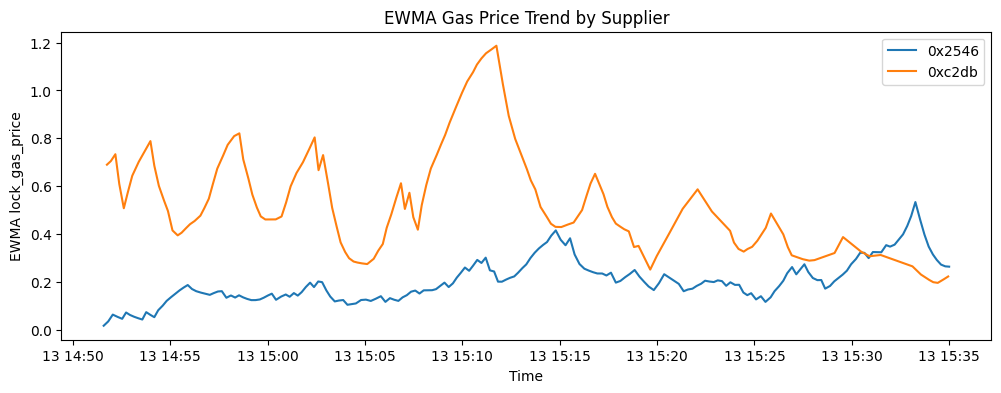

In [125]:
plt.figure(figsize=(12, 4))
for addr, group in df.groupby("address"):
    group = group.sort_values("created_dt")
    ewma = group["lock_gas_price"].ewm(span=10, adjust=False).mean()
    plt.plot(group["created_dt"], ewma, label=addr[:6])
plt.legend()
plt.title("EWMA Gas Price Trend by Supplier")
plt.xlabel("Time")
plt.ylabel("EWMA lock_gas_price")
plt.show()


### LOG

23:42 | 35.3T | $1,454.92 (@ $4,302.34/ETH)

Server Address Lookup Tool
==========================
Available servers: 0-29

可以调查一些这几个机器的网络和内存吗？这几个经常报错

Server Lookup Results:
======================
Valid servers found:
  Server 18: 60.12.103.231
  Server 26: 60.12.103.251
  Server 27: 60.12.103.208

In [126]:
2600000000 / 1e9

2.6